# Intensity Batch & Multidimensional Array Examples

This notebook demonstrates how to use the **Intensity** class with **arrays of parameters** and **batch APIs** for efficient parameter-space exploration.

The key methods covered are:

| Method | Input | Output |
|---|---|---|
| `calc_intensity_batch(T[], N[], dv[])` | 1-D arrays of equal length | `(n_conditions, n_lines)` intensity array |
| `bulk_parameter_update_vectorized(combos)` | List of `{t_kin, n_mol, dv}` dicts | `(n_combos, n_lines)` intensity array |
| `_calc_intensity_core(T, N, dv)` | Broadcastable arrays | `(intensity, tau)` with broadcast shape |

All three bypass the single-parameter cache and run the full vectorized calculation in one pass, giving significant speedups over looping.

## Key Features Demonstrated:
1. **Batch Temperature Sweep** — `calc_intensity_batch` with a 1-D parameter scan
2. **Performance Comparison** — Batch vs. sequential loop timing
3. **2-D Intensity Maps** — Visualise intensity across wavelength and temperature
4. **Named Parameter Combos** — `bulk_parameter_update_vectorized` with dict inputs
5. **2-D Parameter Grids** — Temperature x column-density grids via broadcasting
6. **Line Ratio Diagrams** — Build excitation diagrams from batch results
7. **Column-Density Sensitivity** — Track how individual lines respond to N

In [79]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib widget

# Import data types from iSLAT
from iSLAT.Modules.DataTypes import Intensity, MoleculeLineList
from iSLAT.Modules.FileHandling import hitran_data_folder_path

print("iSLAT data types imported successfully!")

iSLAT data types imported successfully!


In [80]:
# Wavelength window (microns) -- all line lists will be restricted to this range
wavelength_range = (4.5, 5.2)

# Molecule IDs and filenames
mol1_id = "CO"
mol2_id = "H2O"

# Load line lists (filtered to wavelength_range)
data_dir = hitran_data_folder_path

mol1_lines = MoleculeLineList(molecule_id=mol1_id, filename=str(data_dir / f"data_Hitran_{mol1_id}.par"),
                              wavelength_range=wavelength_range)
mol2_lines = MoleculeLineList(molecule_id=mol2_id, filename=str(data_dir / f"data_Hitran_{mol2_id}.par"),
                              wavelength_range=wavelength_range)

print(f"{mol1_id} lines in {wavelength_range[0]}-{wavelength_range[1]} um: {len(mol1_lines)}")
print(f"{mol2_id} lines in {wavelength_range[0]}-{wavelength_range[1]} um: {len(mol2_lines)}")

CO lines in 4.5-5.2 um: 216
H2O lines in 4.5-5.2 um: 2625


## 1. Batch Temperature Sweep

`calc_intensity_batch()` accepts three 1-D arrays of equal length and returns a `(n_conditions, n_lines)` intensity array computed in a single vectorized pass.

In [81]:
# Temperature sweep with constant N and dv
mol1_intens = Intensity(mol1_lines)

temps  = np.linspace(300, 2500, 80)
n_mols = np.full_like(temps, 1e18)
dvs    = np.full_like(temps, 2.0)

batch_result = mol1_intens.calc_intensity_batch(temps, n_mols, dvs)

print(f"Input:  {len(temps)} temperatures from {temps[0]:.0f} to {temps[-1]:.0f} K")
print(f"Output: {batch_result.shape}  (n_conditions x n_lines)")
print(f"Total intensity at T=300 K:  {batch_result[0].sum():.4e}")
print(f"Total intensity at T=2500 K: {batch_result[-1].sum():.4e}")

Input:  80 temperatures from 300 to 2500 K
Output: (80, 216)  (n_conditions x n_lines)
Total intensity at T=300 K:  5.3782e+00
Total intensity at T=2500 K: 1.5205e+05


## 2. Performance: Batch vs. Loop

The batch API avoids per-call overhead (partition-function interpolation, memory allocation, cache checks) by processing all conditions in one NumPy pass.

In [82]:
# --- Batch ---
t0 = time.perf_counter()
batch_result = mol1_intens.calc_intensity_batch(temps, n_mols, dvs)
t_batch = time.perf_counter() - t0

# --- Sequential loop ---
t0 = time.perf_counter()
for i in range(len(temps)):
    mol1_intens.calc_intensity(t_kin=temps[i], n_mol=n_mols[i], dv=dvs[i])
t_loop = time.perf_counter() - t0

print(f"Batch time: {t_batch*1000:.1f} ms  ({len(temps)} conditions)")
print(f"Loop time:  {t_loop*1000:.1f} ms")
print(f"Speedup:    {t_loop / t_batch:.1f}x")

Batch time: 1.9 ms  (80 conditions)
Loop time:  4.7 ms
Speedup:    2.5x


In [83]:
# Repeat with mol2 to show the advantage grows with line-list size
mol2_intens = Intensity(mol2_lines)

t0 = time.perf_counter()
mol2_batch = mol2_intens.calc_intensity_batch(temps, n_mols, dvs)
t_batch_mol2 = time.perf_counter() - t0

t0 = time.perf_counter()
for i in range(len(temps)):
    mol2_intens.calc_intensity(t_kin=temps[i], n_mol=n_mols[i], dv=dvs[i])
t_loop_mol2 = time.perf_counter() - t0

print(f"{mol2_id} ({len(mol2_lines)} lines):")
print(f"  Batch: {t_batch_mol2*1000:.1f} ms")
print(f"  Loop:  {t_loop_mol2*1000:.1f} ms")
print(f"  Speedup: {t_loop_mol2 / t_batch_mol2:.1f}x")

H2O (2625 lines):
  Batch: 19.1 ms
  Loop:  188.8 ms
  Speedup: 9.9x


## 3. 2-D Intensity Maps

The `(n_conditions, n_lines)` batch output maps naturally to `pcolormesh` images.

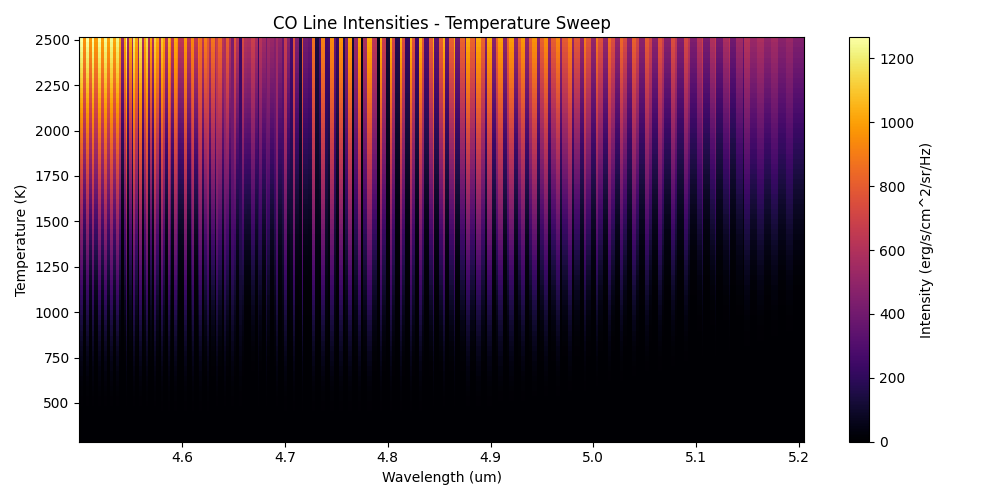

In [84]:
mol1_wl = mol1_lines.get_wavelengths()

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.pcolormesh(mol1_wl, temps, batch_result, shading='nearest', cmap='inferno')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Temperature (K)')
ax.set_title(f'{mol1_id} Line Intensities - Temperature Sweep')
plt.colorbar(im, ax=ax, label='Intensity (erg/s/cm^2/sr/Hz)')

plt.tight_layout()
plt.show()

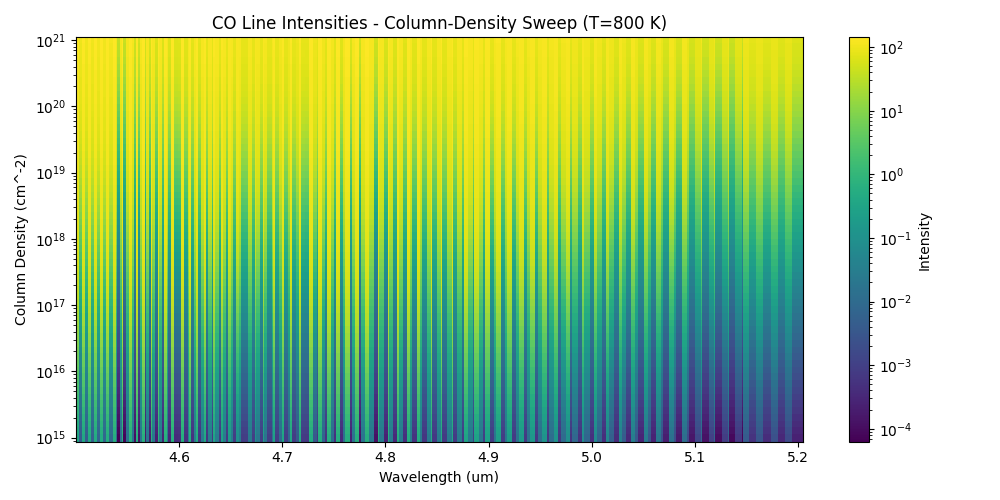

In [85]:
# Column-density sweep at fixed temperature
n_grid = np.logspace(15, 21, 60)
temps_n  = np.full_like(n_grid, 800.0)
dvs_n    = np.full_like(n_grid, 2.0)

n_result = mol1_intens.calc_intensity_batch(temps_n, n_grid, dvs_n)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.pcolormesh(mol1_wl, n_grid, n_result, shading='nearest',
                    cmap='viridis', norm=plt.matplotlib.colors.LogNorm())
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Column Density (cm^-2)')
ax.set_title(f'{mol1_id} Line Intensities - Column-Density Sweep (T=800 K)')
plt.colorbar(im, ax=ax, label='Intensity')

plt.tight_layout()
plt.show()

## 4. Named Parameter Combos

`bulk_parameter_update_vectorized()` accepts a list of dictionaries, each with keys `t_kin`, `n_mol`, and `dv`.  This is convenient when the combinations aren't a simple grid.

In [86]:
# Define a few physically motivated parameter sets
combos = [
    {'t_kin':  300.0, 'n_mol': 1e16, 'dv': 1.0},   # cold, thin
    {'t_kin':  800.0, 'n_mol': 1e18, 'dv': 2.0},   # warm, moderate
    {'t_kin': 1500.0, 'n_mol': 1e19, 'dv': 3.0},   # hot, optically thick
    {'t_kin': 2500.0, 'n_mol': 1e20, 'dv': 5.0},   # very hot, very thick
]

bulk_result = mol1_intens.bulk_parameter_update_vectorized(combos)

print(f"Result shape: {bulk_result.shape}  (n_combos x n_lines)\n")
for i, c in enumerate(combos):
    print(f"Combo {i+1}: T={c['t_kin']:6.0f} K  N={c['n_mol']:.0e}  "
          f"Sum(I)={bulk_result[i].sum():.4e}  Max(I)={bulk_result[i].max():.4e}")

Result shape: (4, 216)  (n_combos x n_lines)

Combo 1: T=   300 K  N=1e+16  Sum(I)=3.6140e-01  Max(I)=1.4491e-02
Combo 2: T=   800 K  N=1e+18  Sum(I)=5.0119e+03  Max(I)=8.0188e+01
Combo 3: T=  1500 K  N=1e+19  Sum(I)=1.3855e+05  Max(I)=9.8301e+02
Combo 4: T=  2500 K  N=1e+20  Sum(I)=8.8641e+05  Max(I)=5.4915e+03


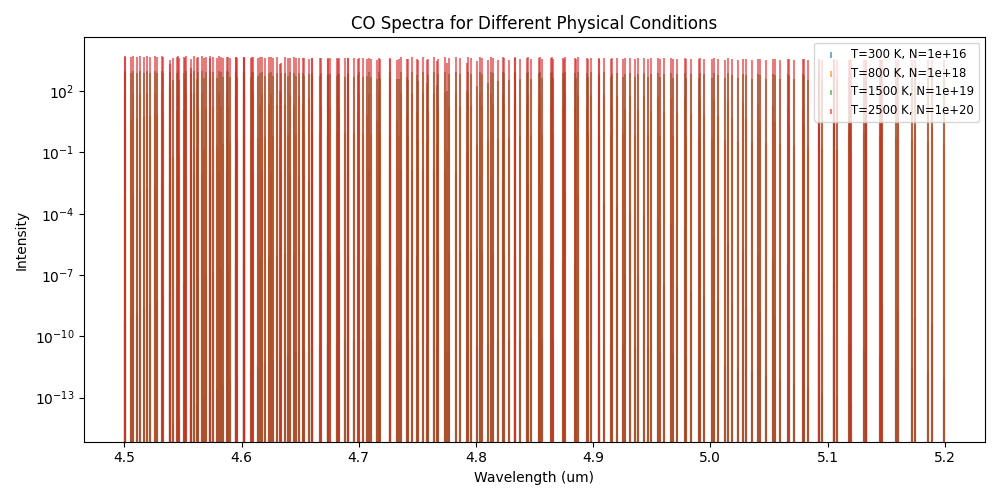

In [87]:
# Overlay the results on a single plot
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.tab10(np.arange(len(combos)))

for i, c in enumerate(combos):
    label = f"T={c['t_kin']:.0f} K, N={c['n_mol']:.0e}"
    markerline, stemlines, baseline = ax.stem(
        mol1_wl, bulk_result[i], markerfmt=' ', basefmt=' ', label=label
    )
    plt.setp(stemlines, color=colors[i], alpha=0.6)
    plt.setp(baseline, visible=False)

ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Intensity')
ax.set_title(f'{mol1_id} Spectra for Different Physical Conditions')
ax.set_yscale('log')
ax.legend(fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()

## 5. 2-D Parameter Grids via Broadcasting

`calc_intensity_batch` requires 1-D arrays of the same length, but you can flatten a 2-D grid, compute in one call, and reshape the result.

In [88]:
# Build a T x N grid
T_axis = np.linspace(300, 2000, 30)
N_axis = np.logspace(16, 20, 25)

T_grid, N_grid = np.meshgrid(T_axis, N_axis)  # both shape (25, 30)
dv_grid = np.full_like(T_grid, 2.0)

# Flatten, compute, reshape
t0 = time.perf_counter()
grid_result = mol1_intens.calc_intensity_batch(
    T_grid.ravel(), N_grid.ravel(), dv_grid.ravel()
)  # shape (750, n_lines)
elapsed = time.perf_counter() - t0

# Reshape to (n_N, n_T, n_lines)
grid_3d = grid_result.reshape(N_grid.shape + (-1,))

print(f"Grid shape: {grid_3d.shape}  (n_N x n_T x n_lines)")
print(f"Total conditions: {T_grid.size}")
print(f"Computed in {elapsed*1000:.1f} ms")

Grid shape: (25, 30, 216)  (n_N x n_T x n_lines)
Total conditions: 750
Computed in 14.2 ms


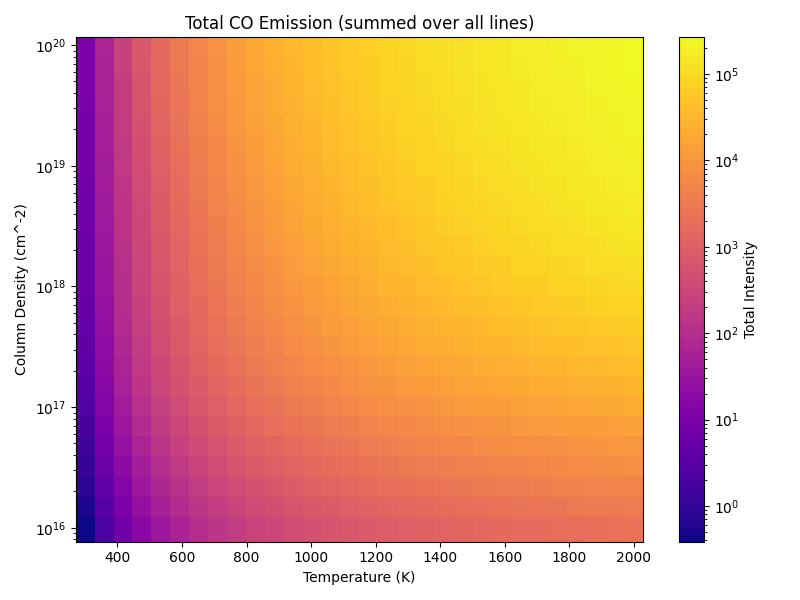

In [89]:
# Sum over all lines to get total emission at each (T, N)
total_emission = grid_3d.sum(axis=2)  # (n_N, n_T)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.pcolormesh(T_axis, N_axis, total_emission, shading='nearest',
                    cmap='plasma', norm=plt.matplotlib.colors.LogNorm())
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Column Density (cm^-2)')
ax.set_title(f'Total {mol1_id} Emission (summed over all lines)')
plt.colorbar(im, ax=ax, label='Total Intensity')

plt.tight_layout()
plt.show()

## 6. Line-Ratio Diagrams

With the full `(n_conditions, n_lines)` array, computing line ratios is just array indexing. This is useful for building excitation diagnostics.

Line A: 4.7326 um  (index 122)
Line B: 4.9681 um  (index 51)


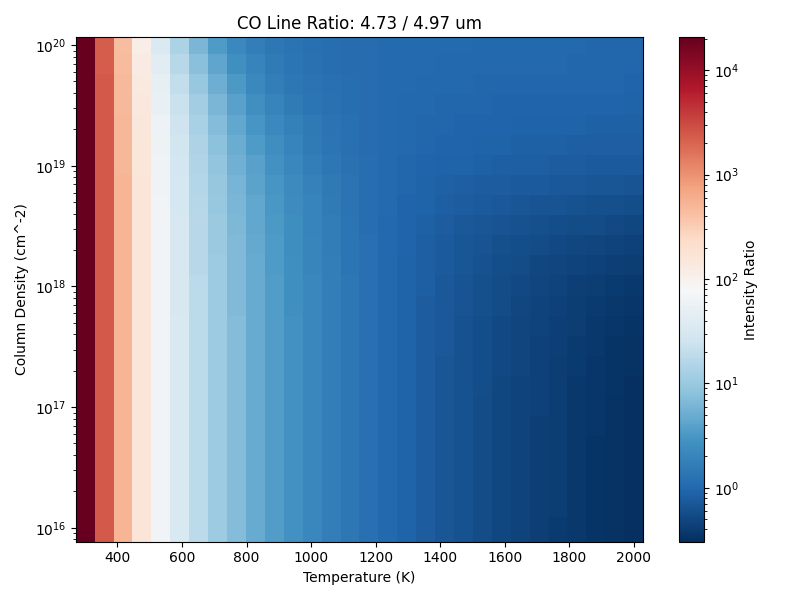

In [90]:
# Pick two lines to use as a ratio diagnostic
mol1_wl = mol1_lines.get_wavelengths()

# Choose lines near the 1/3 and 2/3 points of the loaded wavelength range
wl_lo = mol1_wl.min() + (mol1_wl.max() - mol1_wl.min()) * 0.33
wl_hi = mol1_wl.min() + (mol1_wl.max() - mol1_wl.min()) * 0.67
idx_a = np.argmin(np.abs(mol1_wl - wl_lo))
idx_b = np.argmin(np.abs(mol1_wl - wl_hi))

print(f"Line A: {mol1_wl[idx_a]:.4f} um  (index {idx_a})")
print(f"Line B: {mol1_wl[idx_b]:.4f} um  (index {idx_b})")

# Extract intensities across the T x N grid
I_a = grid_3d[:, :, idx_a]  # (n_N, n_T)
I_b = grid_3d[:, :, idx_b]  # (n_N, n_T)
line_ratio = I_a / np.clip(I_b, 1e-300, None)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.pcolormesh(T_axis, N_axis, line_ratio, shading='nearest', cmap='RdBu_r',
                    norm=plt.matplotlib.colors.LogNorm())
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Column Density (cm^-2)')
ax.set_title(f'{mol1_id} Line Ratio: {mol1_wl[idx_a]:.2f} / {mol1_wl[idx_b]:.2f} um')
plt.colorbar(im, ax=ax, label='Intensity Ratio')

plt.tight_layout()
plt.show()

## 7. Column-Density Sensitivity

Track how individual lines transition from optically thin (intensity proportional to N) to optically thick (intensity saturates) using the batch API.

Sweep shape: (80, 216)


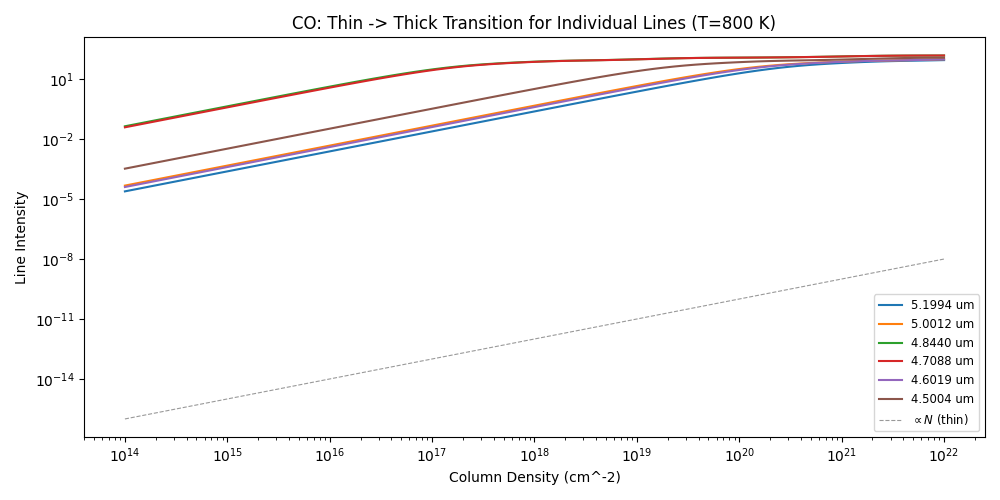

In [91]:
# Column density sweep for selected lines
n_sweep = np.logspace(14, 22, 80)
t_sweep = np.full_like(n_sweep, 800.0)
dv_sweep = np.full_like(n_sweep, 2.0)

sweep_result = mol1_intens.calc_intensity_batch(t_sweep, n_sweep, dv_sweep)
print(f"Sweep shape: {sweep_result.shape}")

# Select a few representative lines from the loaded range
sample_idx = np.linspace(0, len(mol1_wl) - 1, min(6, len(mol1_wl)), dtype=int)
sample_labels = [f'{mol1_wl[i]:.4f} um' for i in sample_idx]

fig, ax = plt.subplots(figsize=(10, 5))
for k, label in enumerate(sample_labels):
    ax.plot(n_sweep, sweep_result[:, sample_idx[k]], label=label)

# Reference slope for optically thin regime
ax.plot(n_sweep, 1e-30 * n_sweep, 'k--', lw=0.8, alpha=0.4, label=r'$\propto N$ (thin)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Column Density (cm^-2)')
ax.set_ylabel('Line Intensity')
ax.set_title(f'{mol1_id}: Thin -> Thick Transition for Individual Lines (T=800 K)')
ax.legend(fontsize='small')

plt.tight_layout()
plt.show()